In [1]:
import pandas as pd
import numpy as np
import fastai
from sklearn.model_selection import StratifiedKFold
import torchvision.models as torch_models
import dill
from fastai.vision.all import *

In [2]:
fastai.__version__

'2.2.5'

In [3]:
kaggle_path = '../input/'
N_SPLITS = 5

In [4]:
train = pd.read_csv(kaggle_path+'train.csv').sample(frac=1, random_state = 2021).reset_index(drop = True)

train['image'] = kaggle_path + 'train_images_512/' + train.chain.astype('str') + '/' + train.image
train['h_c'] = train['hotel_id'].astype('str')+' c'+train['chain'].astype('str')
#train = train[['image','hotel_id']]

In [5]:
train['chain_bucket']=train['chain'].map({0:1,
                                           6:2,
                                           5:3,
                                           90:4,
                                           3:4,
                                           89:4,
                                           87:5,
                                           4:5,
                                           2:5,
                                           88:5,
                                           9:6,
                                           82:6,
                                           78:6}).fillna(0)

In [6]:

skf = StratifiedKFold(n_splits=N_SPLITS, random_state=None, shuffle=False)

train.kfold = -1

for f, (t,v) in enumerate(skf.split(X = train, y = train.hotel_id.values)):
    train.loc[v, 'kfold'] = f

train.groupby('kfold')['hotel_id'].count()

/opt/conda/envs/ml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


kfold
0.0    19512
1.0    19511
2.0    19511
3.0    19511
4.0    19511
Name: hotel_id, dtype: int64

In [7]:
#train=train[train.chain_bucket==6]
train['is_demo_valid'] = False

#train.loc[train['kfold'] == 0, 'is_demo_valid'] = True

train.to_csv('train_folds.csv', index=False)

test=train[train.is_demo_valid == True]
#train=train[train.is_demo_valid == False]

In [8]:
train[(train.is_demo_valid)]#&(train.hotel_id==2252)(train.chain_bucket==4)&

,image,chain,hotel_id,timestamp,h_c,chain_bucket,kfold,is_demo_valid


<AxesSubplot:>

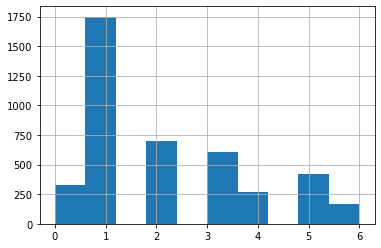

In [9]:
train[train.chain<10][['chain_bucket','hotel_id']].drop_duplicates().chain_bucket.hist()

In [10]:
#train[['chain','hotel_id']].drop_duplicates().groupby('chain').size().sort_values().tail(60)

In [11]:
dls = ImageDataLoaders.from_df(df = train[['image', 'hotel_id', 'is_demo_valid']], path = '.',folder = kaggle_path, valid_col = 'is_demo_valid',
                                item_tfms=Resize(448, method='pad', pad_mode='reflection')#448(224,224)
                               ,batch_tfms=aug_transforms(size=224)
                               ,bs=64) #48#[train.chain_bucket==1][train.chain_bucket==4], label_delim=' '[train.chain_bucket==4]

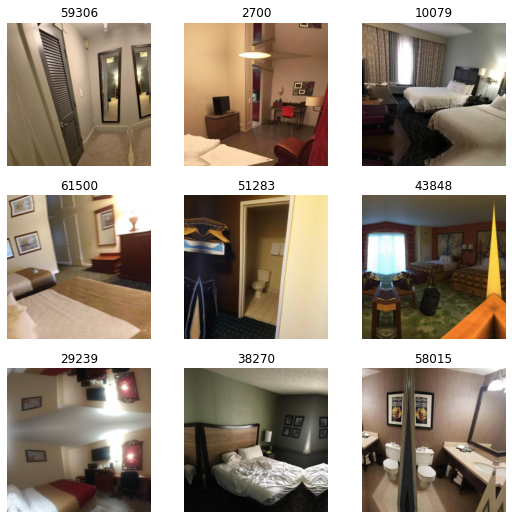

In [12]:
dls.show_batch() 

In [13]:

def myloss(pred,target):
    print(pred.shape,pred[0])
    print(target.shape,target[0])
    
def hotelacc(inp,targ):
    #print(inp.shape, inp[:,:-3].shape)
    inp = inp[:,:-88].topk(k=1, dim=-1)[1]
    targ = targ[:,:-88].topk(k=1, dim=-1)[1]
    return (inp == targ).sum(dim=-1).float().mean()

In [14]:
#https://www.kaggle.com/zzy990106/b0-bert-cv0-9

class ArcMarginProduct_subcenter(nn.Module):
    def __init__(self, in_features, out_features, k=1):
        super().__init__()
        self.weight = nn.Parameter(torch.FloatTensor(out_features*k, in_features))
        self.reset_parameters()
        self.k = k
        self.out_features = out_features
        
        
    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        
    def forward(self, features):
        
        cosine_all = F.linear(F.normalize(features), F.normalize(self.weight))
        cosine_all = cosine_all.view(-1, self.out_features, self.k)
        cosine = torch.mean(cosine_all, dim=2)# cosine, _ =torch.max()
        #cosine,_ = torch.max(cosine_all, dim=2)# cosine, _ =torch.max()
        
        return cosine 
    
class CEMFlat(CrossEntropyLossFlat):
    
    #y_int = True
    @use_kwargs_dict(keep=True, weight=None, ignore_index=-100, reduction='mean')
    def __init__(self, *args, axis=-1, **kwargs):
        self.reduce = kwargs.pop('reduction') if 'reduction' in kwargs else 'mean'
        super().__init__(*args, reduction='none', axis=axis, **kwargs)
    
    def __call__(self, inp, targ, **kwargs):
        
        index = torch.where(targ != -1)[0]
        m_hot = torch.zeros(index.size()[0], inp.shape[1], device=inp.device)
        m_hot.scatter_(1, targ[index,None], 0.3)
        
        #v=inp[0].cpu().detach().numpy()
        x=inp
        x.acos_()
        
        x[index] += m_hot
        x.cos_().mul_(4)#16
        #print('OOO',(inp[0].cpu().detach().numpy()-v).sum())
        
        ce_loss = super().__call__(x, targ, **kwargs)
        #pt = torch.exp(-ce_loss)
        #fl_loss = (1-pt)**self.gamma * ce_loss
        return ce_loss.mean() if self.reduce == 'mean' else ce_loss.sum() if self.reduce == 'sum' else ce_loss

class CEMFlat1(CrossEntropyLossFlat):
    
    #y_int = True
    @use_kwargs_dict(keep=True, weight=None, ignore_index=-100, reduction='mean')
    def __init__(self, *args, axis=-1, **kwargs):
        self.reduce = kwargs.pop('reduction') if 'reduction' in kwargs else 'mean'
        super().__init__(*args, reduction='none', axis=axis, **kwargs)
    
    def __call__(self, inp, targ, **kwargs):
        
        index = torch.where(targ != -1)[0]
        m_hot = torch.zeros(index.size()[0], inp.shape[1], device=inp.device)
        m_hot.scatter_(1, targ[index,None], 0.3)
        
        #inp.acos_()
        inp[index] -= m_hot
        #inp.cos_().mul_(16)
        
        ce_loss = super().__call__(inp, targ, **kwargs)
        #pt = torch.exp(-ce_loss)
        #fl_loss = (1-pt)**self.gamma * ce_loss
        return ce_loss.mean() if self.reduce == 'mean' else ce_loss.sum() if self.reduce == 'sum' else ce_loss

In [15]:
#c_w = (1-torch.Tensor((train[['image', 'chain_bucket']].groupby(['chain_bucket']).count()).cuda())) #/train.shape[0])['fold'].values).cuda())/5
#
#learn = cnn_learner(dls, resnet34,metrics=hotelacc)#partial(accuracy_multi, thresh=0.5))#metrics=[accuracy, top_k_accuracy])#, loss_func = myloss) #CrossEntropyLossFlat(weight = c_w)) #torch_models.resnext101_32x8d

learn = cnn_learner(dls, resnet101, metrics=[accuracy, top_k_accuracy], opt_func=QHAdam).to_fp16() #, loss_func= cep_margin), loss_func=CEMFlat()
#learn.model[1].add_module('arcM',ArcMarginProduct_subcenter(dls.c,dls.c, k=3))

In [16]:
a = Tensor([[1,2,3],[4,5,6],[7,8,9],[11,22,33]])
b = LongTensor([1,2,2,1]).T

index = torch.where(b != -1)[0]
m_hot = torch.zeros(4, 3)
m_hot.scatter_(1, b[index,None], 0.3)
m_hot

tensor([[0.0000, 0.3000, 0.0000],
        [0.0000, 0.0000, 0.3000],
        [0.0000, 0.0000, 0.3000],
        [0.0000, 0.3000, 0.0000]])

In [17]:
dls.c, learn.loss_func

(7770, FlattenedLoss of CrossEntropyLoss())

In [18]:
dls.vocab[20],learn.loss_func
#learn.model

(166, FlattenedLoss of CrossEntropyLoss())

SuggestedLRs(lr_min=0.003981071710586548, lr_steep=1.5848931980144698e-06)

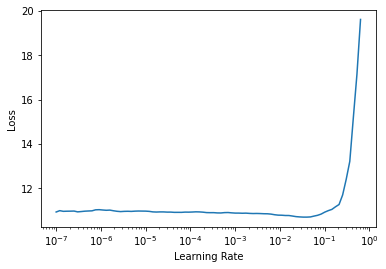

In [19]:
#learn.model

learn.lr_find()

In [20]:
#learn.fine_tune(1, 0.005) 
#learn.loss_func=CEMFlat1()
#learn.freeze()
#learn.fit_one_cycle(1,0.005)
learn.fine_tune(10, 0.005, freeze_epochs=1) #, cbs=MixUp()) 

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,7.751590,None,None,None,09:57


/opt/conda/envs/ml/lib/python3.6/site-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,6.515024,None,None,None,12:39
1,5.414533,None,None,None,12:39
2,4.532347,None,None,None,12:40
3,3.662028,None,None,None,12:45
4,2.922284,None,None,None,12:41
5,2.222001,None,None,None,12:41
6,1.582072,None,None,None,12:41
7,1.017064,None,None,None,12:41
8,0.727301,None,None,None,12:41
9,0.591004,None,None,None,12:41


In [21]:
#res101
epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	8.093964	7.615144	0.052839	0.103834	09:14
    
#res50 all padded resize HQAdam

epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	8.184557	7.738400	0.040539	0.087792	06:20
epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	7.156171	6.764578	0.118337	0.201312	07:33
1	6.017654	5.547440	0.184348	0.315703	07:32
2	4.954804	4.669734	0.267579	0.426558	07:32
3	3.984981	3.975394	0.347940	0.518860	07:33
4	3.183610	3.529619	0.413182	0.579541	07:33
5	2.435921	3.219519	0.461767	0.627921	07:33
6	1.760477	2.960891	0.501435	0.664565	07:33
7	1.152619	2.846337	0.530750	0.684348	07:33
8	0.778958	2.771853	0.542845	0.698032	07:33
9	0.689957	2.764618	0.544793	0.700236	07:34


#res50 all no aug HQAdam

epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	8.099021	7.672452	0.050072	0.101630	05:14
epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	7.024560	6.701533	0.128126	0.211870	06:29
1	5.970382	5.522499	0.193983	0.320418	06:29
2	4.949619	4.684256	0.270090	0.423995	06:51
3	3.968697	4.048282	0.344762	0.510865	06:42
4	3.105205	3.661313	0.395705	0.568163	06:41
5	2.294243	3.367522	0.444957	0.611572	06:33
6	1.541104	3.225096	0.480320	0.642118	06:29
7	0.893848	3.128287	0.504715	0.662208	06:29
8	0.559355	3.067192	0.516913	0.669690	06:29
9	0.424328	3.068796	0.518604	0.670869	06:29

#res18 all no aug HQAdam
epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	8.341456	7.959477	0.030955	0.072673	03:06
epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	7.413188	7.142485	0.093635	0.166974	03:11
1	6.404679	6.042042	0.151650	0.258354	03:06
2	5.483971	5.239201	0.214535	0.351732	03:07
3	4.578401	4.704397	0.273370	0.422304	03:07
4	3.691679	4.311640	0.321751	0.482011	03:07
5	2.874237	4.071184	0.357934	0.520295	03:07
6	2.022992	3.953137	0.384584	0.547458	03:07
7	1.294686	3.898506	0.407749	0.566728	03:07
8	0.911542	3.893287	0.415795	0.574313	03:07
9	0.699958	3.878108	0.419280	0.574262	03:08

#res18 all no aug RAdam
epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	8.411447	8.076100	0.029520	0.070111	03:04
epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	7.633208	7.423437	0.084461	0.145244	03:09
1	7.284482	6.899840	0.124026	0.206796	03:03
2	7.091481	6.547528	0.147191	0.239904	03:03
3	6.634479	6.107715	0.185886	0.285722	03:03
4	6.206453	5.735046	0.222940	0.335691	03:03
5	5.767170	5.427281	0.257380	0.372130	03:03
6	5.315634	5.168352	0.285517	0.407595	03:03
7	4.635815	5.030865	0.311142	0.436039	03:04
8	4.172212	4.974858	0.323032	0.444239	03:03
9	3.770682	4.978349	0.324160	0.446546	03:15
    
#res18 all no aug
epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	8.411445	8.083024	0.030802	0.069803	03:03
epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	7.666475	7.439775	0.086613	0.150215	03:09
1	7.293564	6.869984	0.121361	0.202901	03:01
2	7.036803	6.532573	0.146166	0.237085	03:01
3	6.737561	6.142245	0.179479	0.284235	03:02
4	6.223575	5.787226	0.219813	0.326876	03:02
5	5.793545	5.461564	0.251538	0.367722	03:02
6	5.248749	5.201982	0.284594	0.405648	03:01
7	4.679545	5.046185	0.309194	0.430556	03:02
8	4.138177	5.009431	0.319342	0.441318	03:02
9	3.801219	5.006034	0.320418	0.442497	03:02

#res18 all
epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	8.467572	8.124553	0.025625	0.058989	04:17
epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	7.801481	7.538846	0.074467	0.134481	04:17
1	7.425799	6.982706	0.110137	0.187936	04:15
2	7.253185	6.570155	0.142271	0.232062	04:16
3	6.846573	6.225223	0.174200	0.272499	04:16
4	6.531587	5.860997	0.208641	0.312782	04:16
5	6.134465	5.514784	0.242005	0.359369	04:16
6	5.772475	5.270198	0.273626	0.396218	04:16
7	5.324565	5.109622	0.300789	0.421484	04:16
8	4.918991	5.040721	0.312679	0.432708	04:17
9	4.634564	5.045669	0.314422	0.431171	04:17

SyntaxError: invalid syntax (<ipython-input-21-db866468e482>, line 2)

In [22]:
learn.export(f'export_res101_Fall_HQAdam.pkl',pickle_module=dill)

In [ ]:
train #[train.is_demo_valid==False]0.008929	0.012500	

In [ ]:
prob, tar, pred = learn.get_preds(ds_idx=1,with_decoded=True)

#test_dl=learn.dls.test_dl(train[['image','hotel_id']].iloc[440:600])
#prob, tar =learn.get_preds(dl=test_dl)#ds_idx=1,with_decoded=True)
prob, tar

In [ ]:
#learn.dls[1].after_batch #.dataset[0]

In [ ]:
prob[0].topk(5) ,tar[0], dls.vocab[342], prob.shape,prob[0][342]

In [ ]:
test_dl=learn.dls.test_dl(test, item_tfms=Resize(448), batch_tfms=aug_transforms(size=224))
prob, tar =learn.get_preds(dl=test_dl)#ds_idx=1,with_decoded=True)
prob, tar

In [ ]:
#test_dl.after_batch

In [ ]:
prob[0].topk(10) , dls.vocab[342], prob.shape,prob[0][342]

In [ ]:
test_dl.dataset[0]#.show()

In [ ]:
epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	6.725233	6.691653	0.025446	0.054464	00:43
epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	6.666232	6.648721	0.061607	0.118750	00:49
    
# chain4 res18
epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	7.417761	6.129266	0.055804	0.137946	00:32
epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	5.712602	5.375559	0.122321	0.237054	00:32
1	5.034863	4.860949	0.177232	0.305804	00:34
2	4.528499	4.417047	0.211607	0.365625	00:32
3	3.875956	4.055223	0.249107	0.416518	00:34
4	3.239520	3.767382	0.287946	0.466071	00:34
5	2.583438	3.546301	0.326339	0.500893	00:32
6	1.948013	3.359771	0.359821	0.548214	00:34
7	1.464740	3.260402	0.383036	0.563839	00:33
8	1.183184	3.219965	0.389732	0.568304	00:35
9	1.036684	3.208099	0.388839	0.567857	00:33

    
# chain4 res18 with arc(k5 mean)
epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	6.541726	6.526719	0.700000	0.992857	00:42
epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	6.516261	6.510182	0.658482	0.985268	00:49
1	6.501825	6.492661	0.595536	0.983482	00:49
2	6.486174	6.478865	0.519196	0.966518	00:49
3	6.468045	6.462359	0.508482	0.964732	00:49
4	6.450371	6.449969	0.526339	0.970089	00:49
5	6.434631	6.437826	0.562500	0.978125	00:49
6	6.419397	6.428612	0.575446	0.977679	00:49
7	6.410842	6.423662	0.598661	0.972321	00:49
8	6.401272	6.421358	0.606250	0.972321	00:49
9	6.398186	6.420961	0.602679	0.973214	00:49

# chain4 res18 with arc(k1)
epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	6.524926	6.491221	0.189286	0.529018	00:41
epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	6.468594	6.452563	0.254018	0.577679	00:48
1	6.432246	6.414721	0.264286	0.583036	00:48
2	6.399032	6.379938	0.274554	0.568750	00:48
3	6.360778	6.347869	0.288393	0.592411	00:48
4	6.324476	6.321461	0.324107	0.616964	00:48
5	6.286507	6.296262	0.345982	0.645536	00:48
6	6.258912	6.276107	0.374107	0.659821	00:48
7	6.232644	6.264833	0.398214	0.683482	00:48
8	6.211616	6.259295	0.410714	0.688393	00:49
9	6.205580	6.258278	0.407143	0.687054	00:49

In [ ]:
learn.export(f'export.pkl')

In [ ]:
#res50 bs64 arcm, cem +=m
epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	8.837965	8.831619	0.308682	0.775369	06:25
epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	8.823522	8.819674	0.291052	0.770603	07:20
1	8.812909	8.806095	0.211665	0.692394	07:23
2	8.799928	8.790311	0.182093	0.600041	07:22
3	8.786133	8.772222	0.179069	0.593276	07:19
4	8.772529	8.756088	0.195521	0.591328	07:21
5	8.759800	8.741478	0.205258	0.600451	07:21
6	8.749186	8.730001	0.216533	0.615262	07:22
7	8.736682	8.721563	0.230422	0.637198	07:22
8	8.731894	8.717832	0.236419	0.638428	07:21
9	8.730051	8.717113	0.238161	0.639196	07:41
    
#res50 bs64
epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	8.317183	7.921312	0.040590	0.085588	08:20
epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	7.528651	7.170936	0.105371	0.175482	10:13
1	7.204895	6.653473	0.142886	0.232677	10:20
2	6.941136	6.286196	0.167589	0.267374	10:05
3	6.528665	5.755139	0.214996	0.324160	10:03
4	6.070248	5.317997	0.256970	0.379561	10:02
5	5.609989	4.938997	0.302327	0.429274	10:03
6	5.157987	4.606316	0.342968	0.484112	10:05
7	4.599042	4.396810	0.379920	0.516298	10:04
8	4.102228	4.315802	0.398011	0.533210	10:18
9	3.682967	4.314715	0.398268	0.534697	10:06
    

#res34
epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	8.415315	8.058720	0.032288	0.069906	04:42
epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	7.686148	7.397623	0.091636	0.154110	05:34
1	7.316401	6.885247	0.119721	0.199826	05:33
2	7.127475	6.494644	0.142118	0.239442	05:34
3	6.733458	6.087039	0.181478	0.288592	05:30
4	6.380781	5.688229	0.223555	0.335332	05:29
5	5.979268	5.359049	0.261685	0.380791	05:30
6	5.593188	5.036254	0.295613	0.425123	05:30
7	5.061710	4.871400	0.325543	0.452132	05:30
8	4.684802	4.782250	0.341021	0.465406	05:30
9	4.308330	4.780612	0.341636	0.466277	05:30


#res18

epoch	train_loss	valid_loss	accuracy	time
0	8.451213	8.127793	0.026804	04:26
epoch	train_loss	valid_loss	accuracy	time
0	7.786336	7.513499	0.076825	04:27
1	7.461221	6.939682	0.115314	04:24
2	7.167302	6.559566	0.142938	04:25
3	6.890818	6.188414	0.171382	04:26
4	6.566433	5.831934	0.210076	04:21
5	6.208480	5.529561	0.243645	04:21
6	5.687847	5.275159	0.276394	04:21
7	5.288332	5.110462	0.298944	04:22
8	4.922027	5.043629	0.313089	04:22
9	4.557464	5.023990	0.314678	04:22

In [ ]:
interp = Interpretation.from_learner(learn)

interp.plot_top_losses(9, figsize=(15,10))

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

interp.plot_confusion_matrix(figsize=(7,7))

In [ ]:
## chain 1 resnext101
epoch	train_loss	valid_loss	accuracy	time
0	7.180262	6.626441	0.070600	06:16
epoch	train_loss	valid_loss	accuracy	time
0	6.094551	5.974283	0.141940	08:45
1	5.705760	5.458116	0.187361	08:44
2	5.353799	5.179721	0.218465	08:45
3	5.045684	4.787757	0.257961	08:45
4	4.388067	4.463748	0.303629	08:45
5	3.814906	4.214329	0.338929	08:45
6	3.151538	3.996331	0.366329	08:49
7	2.589321	3.854836	0.391755	08:45
8	2.137407	3.786668	0.409775	08:44
9	1.722539	3.783929	0.407307	08:45

In [ ]:
## chain
epoch	train_loss	valid_loss	accuracy	time
0	2.900834	2.685299	0.316796	25:11
epoch	train_loss	valid_loss	accuracy	time
0	2.420417	2.304435	0.414997	25:27
1	2.007528	1.878275	0.515709	25:28
2	1.694720	1.675625	0.568859	25:31